# Projeto de Machine Learning II 
Projeto final do curso de Machine Learning II da Turma Santander Coders 2023 - Trilha de Data Science - Turma 1008.

Integrantes:
- [Anna Clara Amâncio](https://github.com/claraamancio)
- [Manusa Leal](https://github.com/manusaleal)

Este projeto possui como objetivo a realização da segmentação de clientes através de modelos não supervisionados.
A segmentação de clientes é importante para áreas como marketing e vendas dentro das empresas, pois desta forma é possível criar campanhas e melhores táticas de vendas com uma assertividade melhor.

O dataset possui informações demográficas relevantes dos clientes, sendo elas:

- Sexo biológico: 0: Masculino, 1: Feminino
- Estado civil: 0: Solteiro, 1: Não solteiro (divorciado/separado/casado/viúvo)
- Idade: Valor mínimo de 18, valor máximo de 78
- Educação: 0: outro/desconhecido, 1: ensino médio, 2: universidade, 3: pós-graduação
- Renda: Renda anual autodeclarada em dólares americanos do cliente (USD 35832 Valor mínimo e USD 309364 Valor máximo)
- Ocupação: 0: desempregado/não qualificado, 1: funcionário qualificado, 2: funcionário altamente qualificado
- Tamanho do assentamento (tamanho da cidade que o cliente reside baseado na quantidade de pessoas): 0: cidade pequena, 1: cidade média, 2: cidade grande

# 1. Preparação dos Dados e Verificação de Consistência

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster import hierarchy
from sklearn.cluster import DBSCAN, dbscan, KMeans, k_means, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet

import warnings 
warnings.filterwarnings('ignore')

In [126]:
data = pd.read_csv('segmentation data.csv')
df = pd.DataFrame(data)
df

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
...,...,...,...,...,...,...,...,...
1995,100001996,1,0,47,1,123525,0,0
1996,100001997,1,1,27,1,117744,1,0
1997,100001998,0,0,31,0,86400,0,0
1998,100001999,1,1,24,1,97968,0,0


In [127]:
df.shape

(2000, 8)

In [128]:
df.columns

Index(['ID', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size'],
      dtype='object')

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [130]:
df.describe()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,1.000010e+08,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,5.774946e+02,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,1.000000e+08,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,1.000005e+08,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,1.000010e+08,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000015e+08,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000020e+08,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


# Análise Exploratória de Dados

In [131]:
#Criando uma função para substituir os labels para os gráficos
def temp_df(df):
    temp_df = df.copy()
    temp_df = temp_df.rename(columns={"Sex": "Sexo", "Marital status": "Estado Civil", "Education": "Educação", 
                                      "Occupation": "Ocupação", "Settlement size": "Tamanho do Assentamento",
                                      "Age": "Idade", "Income": "Renda"})
    temp_df['Sexo'] = temp_df['Sexo'].replace(0, 'Masculino')
    temp_df['Sexo'] = temp_df['Sexo'].replace(1, 'Feminino')
    temp_df['Estado Civil'] = temp_df['Estado Civil'].replace(0, 'Solteiro')
    temp_df['Estado Civil'] = temp_df['Estado Civil'].replace(1, 'Não Solteiro')
    temp_df['Educação'] = temp_df['Educação'].replace(0, 'Outro/Desconhecido')
    temp_df['Educação'] = temp_df['Educação'].replace(1, 'Ensino Médio')
    temp_df['Educação'] = temp_df['Educação'].replace(2, 'Universidade')
    temp_df['Educação'] = temp_df['Educação'].replace(3, 'Pós-graduação')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(0, 'Desempregado/Não qualificado')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(1, 'Funcionário qualificado')
    temp_df['Ocupação'] = temp_df['Ocupação'].replace(2, 'Funcionário altamente qualificado')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(0, 'Cidade Pequena')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(1, 'Cidade Média')
    temp_df['Tamanho do Assentamento'] = temp_df['Tamanho do Assentamento'].replace(2, 'Cidade Grande')
    return temp_df

In [132]:
df_eda = temp_df(df)

In [133]:
df_eda

,ID,Sexo,Estado Civil,Idade,Educação,Renda,Ocupação,Tamanho do Assentamento
0,100000001,Masculino,Solteiro,67,Universidade,124670,Funcionário qualificado,Cidade Grande
1,100000002,Feminino,Não Solteiro,22,Ensino Médio,150773,Funcionário qualificado,Cidade Grande
2,100000003,Masculino,Solteiro,49,Ensino Médio,89210,Desempregado/Não qualificado,Cidade Pequena
3,100000004,Masculino,Solteiro,45,Ensino Médio,171565,Funcionário qualificado,Cidade Média
4,100000005,Masculino,Solteiro,53,Ensino Médio,149031,Funcionário qualificado,Cidade Média
...,...,...,...,...,...,...,...,...
1995,100001996,Feminino,Solteiro,47,Ensino Médio,123525,Desempregado/Não qualificado,Cidade Pequena
1996,100001997,Feminino,Não Solteiro,27,Ensino Médio,117744,Funcionário qualificado,Cidade Pequena
1997,100001998,Masculino,Solteiro,31,Outro/Desconhecido,86400,Desempregado/Não qualificado,Cidade Pequena
1998,100001999,Feminino,Não Solteiro,24,Ensino Médio,97968,Desempregado/Não qualificado,Cidade Pequena


### Distribuição das Variáveis Categóricas

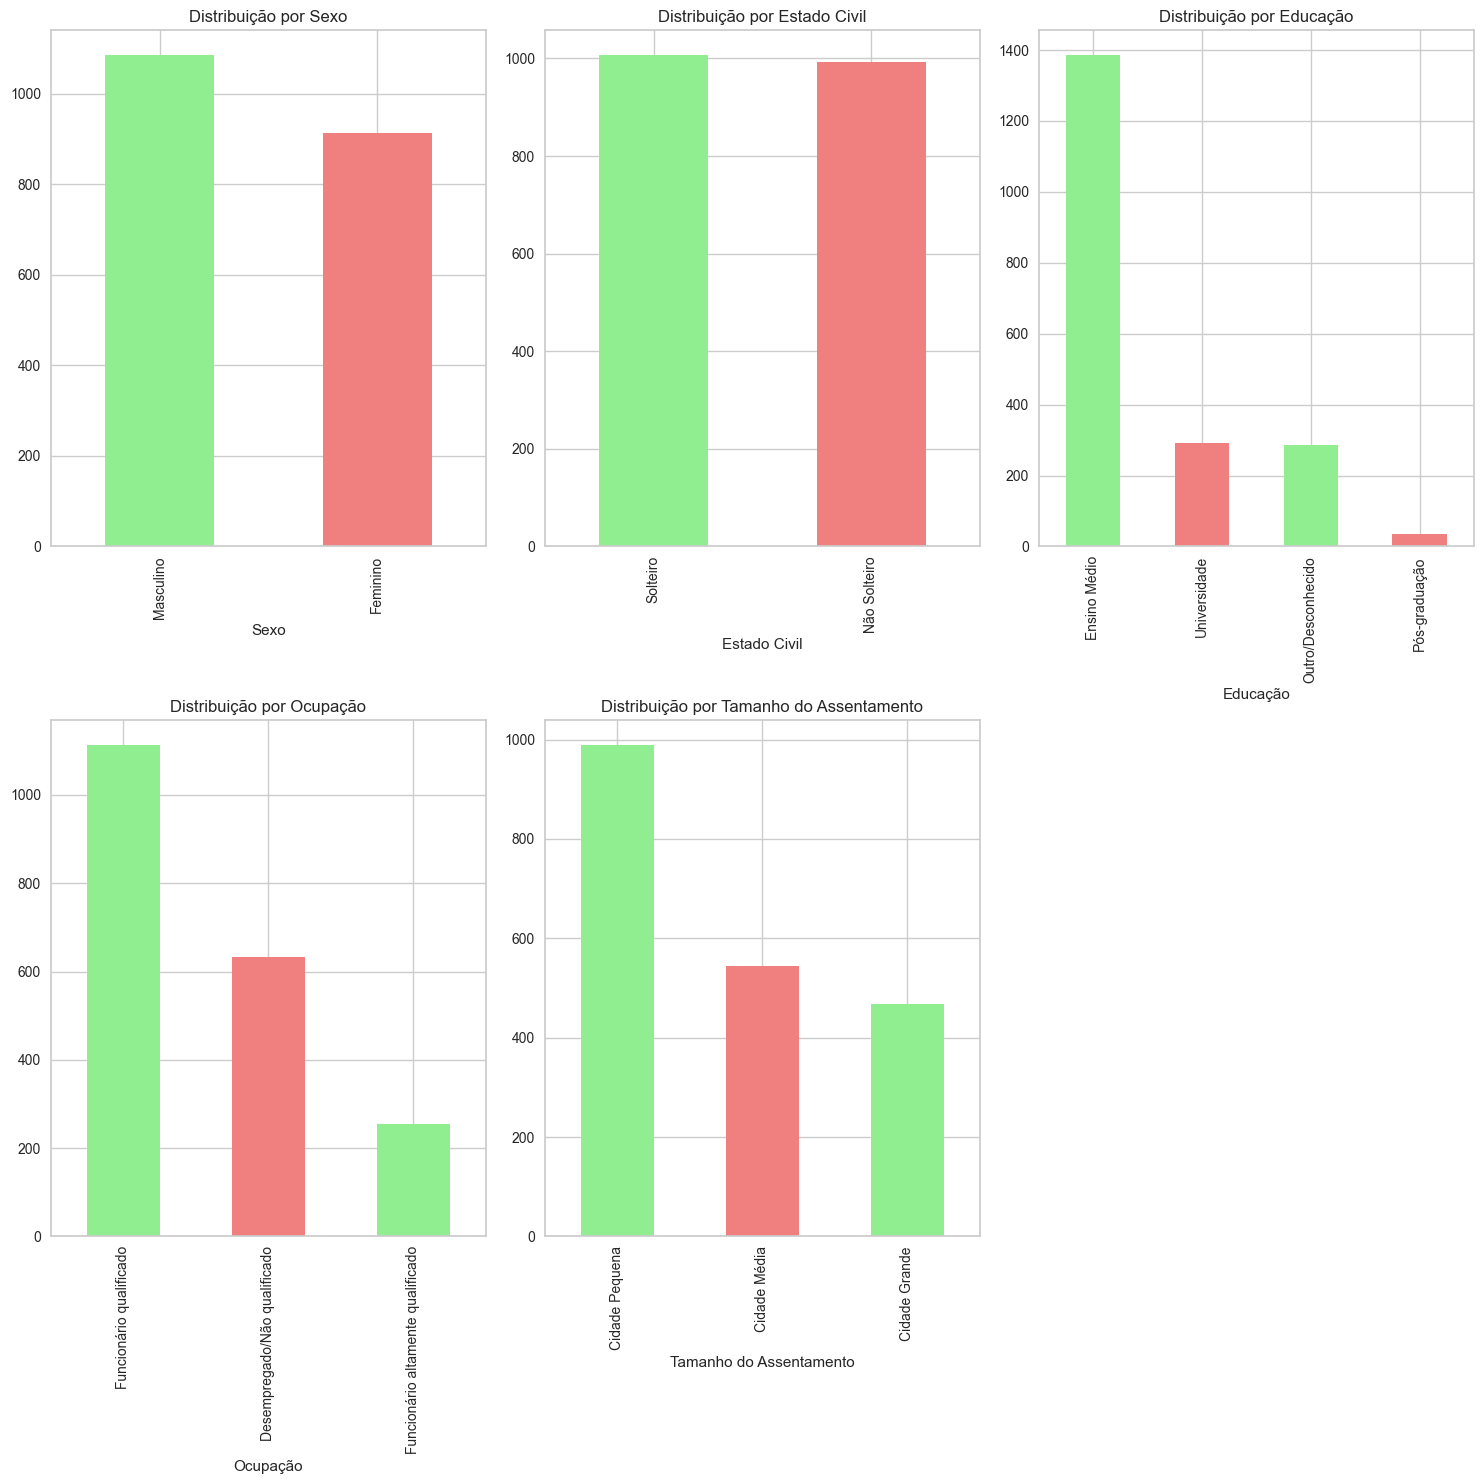

In [134]:
# Contando a ocorrência para cada categoria
sexo_counts = df_eda['Sexo'].value_counts()
estado_civil_counts = df_eda['Estado Civil'].value_counts()
educacao_counts = df_eda['Educação'].value_counts()
ocupacao_counts = df_eda['Ocupação'].value_counts()
assentamento_counts = df_eda['Tamanho do Assentamento'].value_counts()

paleta = ['lightgreen', 'lightcoral']

# Criando os subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Plot para 'Sexo'
sexo_counts.plot(kind='bar', ax=axes[0, 0], color=paleta)
axes[0, 0].set_title('Distribuição por Sexo')

# Plot para 'Estado Civil'
estado_civil_counts.plot(kind='bar', ax=axes[0, 1], color=paleta)
axes[0, 1].set_title('Distribuição por Estado Civil')

# Plot para 'Educação'
educacao_counts.plot(kind='bar', ax=axes[0, 2], color=paleta)
axes[0, 2].set_title('Distribuição por Educação')

# Plot para 'Ocupação'
ocupacao_counts.plot(kind='bar', ax=axes[1, 0], color=paleta)
axes[1, 0].set_title('Distribuição por Ocupação')

# Plot para 'Tamanho do Assentamento'
assentamento_counts.plot(kind='bar', ax=axes[1, 1], color=paleta)
axes[1, 1].set_title('Distribuição por Tamanho do Assentamento')

# Removendo subplots vazios
fig.delaxes(axes[1, 2])

# Ajuste de layout
plt.tight_layout()
plt.show()

- A Distribuição por Estado Civil é a que possui uma proporção melhor balanceada, seguida pelo Sexo. 

- Já a Educação, Ocupação e tamanho do Assentamento estão desbalanceados. 
- Na distribuição da Educação, grande quantidade de pessoas que possuem o Ensino Médio e menos de 50 pessoas possuem a pós graduação.

- Para a Ocupação, muitos funcionários qualificados e muitas pessoas são de Cidade Pequena.

### Distribuição das Variáveis Numéricas

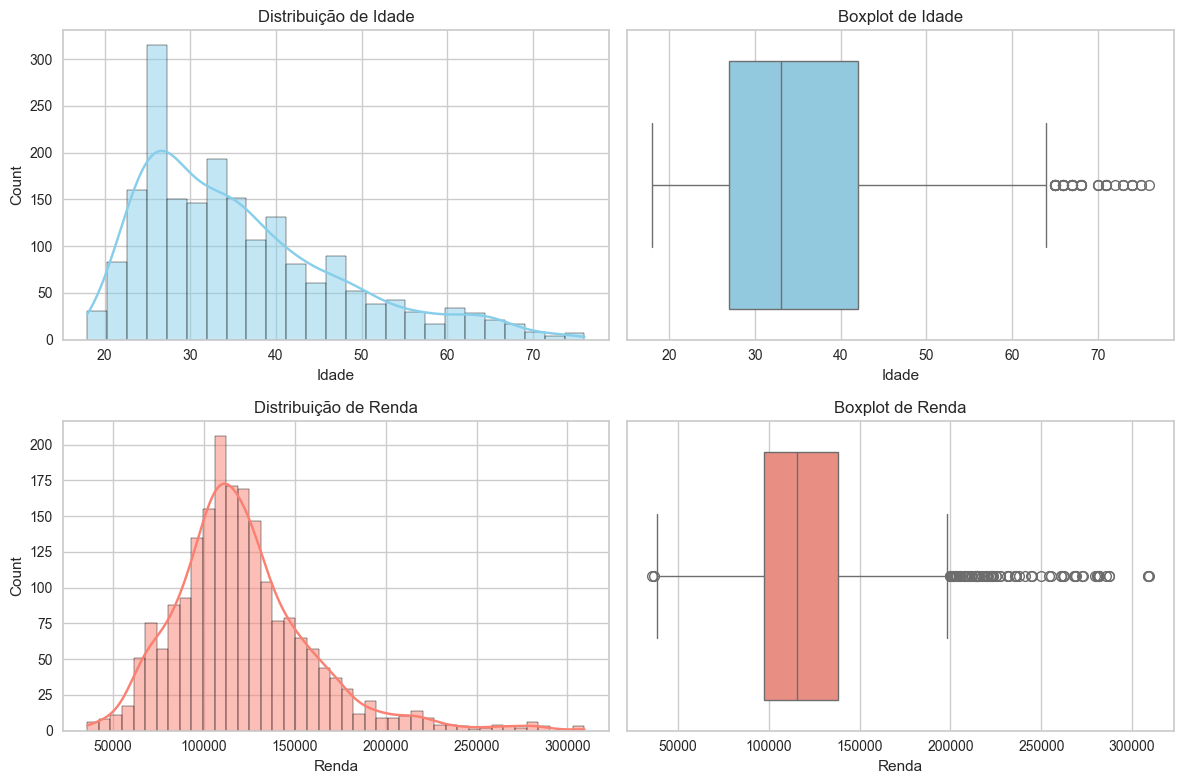

In [135]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Distribution plot for 'Idade'
sns.histplot(df_eda['Idade'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribuição de Idade')

# Boxplot for 'Idade'
sns.boxplot(x=df_eda['Idade'], ax=axes[0, 1], color='skyblue')
axes[0, 1].set_title('Boxplot de Idade')

# Distribution plot for 'Renda'
sns.histplot(df_eda['Renda'], kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Distribuição de Renda')

# Boxplot for 'Renda'
sns.boxplot(x=df_eda['Renda'], ax=axes[1, 1], color='salmon')
axes[1, 1].set_title('Boxplot de Renda')

# Adjust layout
plt.tight_layout()
plt.show()

In [136]:
#Valores exatos da média e mediana
numeric_columns = df_eda[['Idade', 'Renda']]
numeric_columns.describe()

,Idade,Renda
count,2000.000000,2000.000000
mean,35.909000,120954.419000
std,11.719402,38108.824679
min,18.000000,35832.000000
25%,27.000000,97663.250000
50%,33.000000,115548.500000
75%,42.000000,138072.250000
max,76.000000,309364.000000


Observando a distribuição de idade, temos que o gráfico está deslocado para a esquerda, indicando que a média (35.9) é maior que a mediana. O boxplot indica que a mediana está próxima dos 33 anos, contendo alguns outliers no limite superior.

Já para a distribuição de renda, ela está levemente desloacada para a esquerda, tendo um boxplot com distribuição um pouco mais simétrico do que a idade. A maioria dos outliers estão no limite superior.

# Modelos de Clusterização não supervisionado

Vamos estudar os algoritmos KMeans, Hierárquico e DBScan. Primeiro, vamos investigar o melhor número de clusters a serem adotados nos modelos KMeans e Hierárquico utilizando o Método do Cotovelo e o melhor número epsilon a ser adotado nos modelos DBScan usando o Método dos Vizinhos Próximos. Depois, montaremos um DataFrame com as métricas de cada modelo, a fim de escolher o algoritmo ideal para o problema em questão.

In [137]:
df.drop('ID', axis=1, inplace=True)

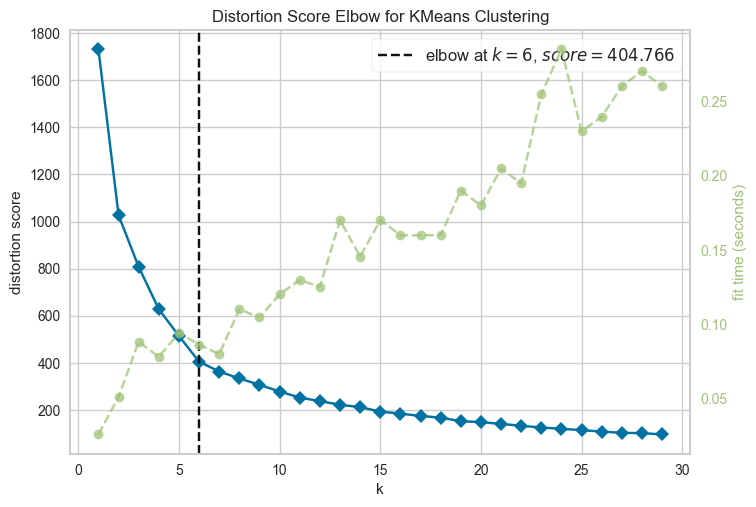

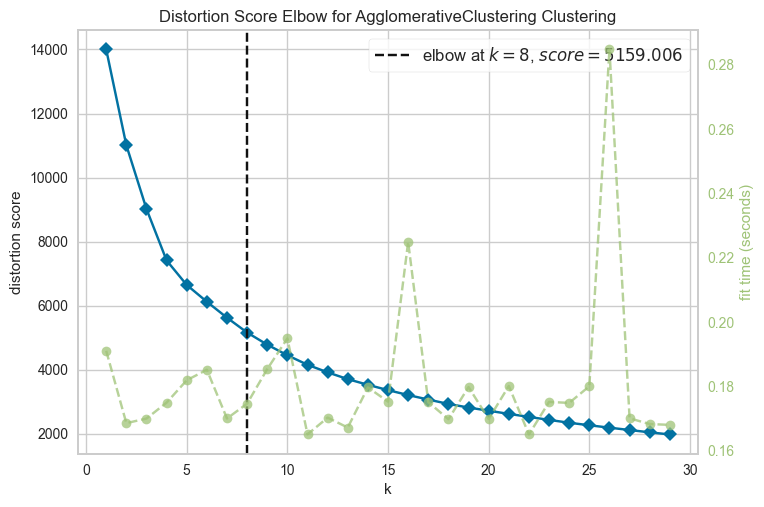

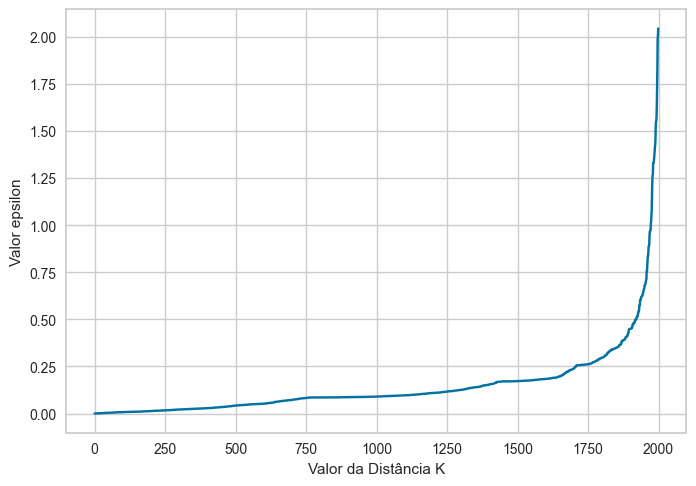

In [138]:
# Padronizando os dados com StandardScaler
scaler_std = StandardScaler()
data_std = scaler_std.fit_transform(df)

# Padronizando os dados com MinMax
scaler_minmax = MinMaxScaler()
data_minmax = scaler_minmax.fit_transform(df)

# Método do Cotovelo
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k = (1, 30)) 
visualizer.fit(data_minmax)
visualizer.show()

# Método do Cotovelo
aglo = AgglomerativeClustering()
visualizer = KElbowVisualizer(aglo, k = (1, 30)) 
visualizer.fit(data_std)
visualizer.show()

# Método dos Vizinhos Próximos
neighbors = NearestNeighbors(n_neighbors = 14)
neighbors_fit = neighbors.fit(data_std)
distances, indices = neighbors_fit.kneighbors(data_std)
distances = np.sort(distances, axis = 0)
plt.plot(distances[:, 1])
plt.xlabel("Valor da Distância K")
plt.ylabel("Valor epsilon")
plt.show()

Para o algoritmo KMeans e para o algoritmo hierárquico o melhor número de clusters a ser utilizado é 7 e 8. Iremos adotar o valor 0.4 para o parâmetro episilon no algoritmo DBScan.

In [139]:
def avaliar_modelos(algoritmos, metricas, data):
    for nome, algoritmo in algoritmos.items():
        metricas["Modelo"].append(nome)
        if "KMeans" in nome:
            scaler_minmax = MinMaxScaler()
            data_minmax = scaler_minmax.fit_transform(df) 
            algoritmo.fit(data_minmax)
            metricas["Silhouette Score"].append(silhouette_score(data_minmax, algoritmo.labels_))
            metricas["Calinski and Harabasz Score"].append(calinski_harabasz_score(data_minmax, algoritmo.labels_))
            metricas["Davies-Bouldin Score"].append(davies_bouldin_score(data_minmax, algoritmo.labels_))
        else:
            scaler_std = StandardScaler()
            data_std = scaler_std.fit_transform(df)
            algoritmo.fit(data_std)
            metricas["Silhouette Score"].append(silhouette_score(data_std, algoritmo.labels_))
            metricas["Calinski and Harabasz Score"].append(calinski_harabasz_score(data_std, algoritmo.labels_))
            metricas["Davies-Bouldin Score"].append(davies_bouldin_score(data_std, algoritmo.labels_)) 
    return metricas


In [140]:
metricas = {
    "Modelo": [],
    "Silhouette Score": [],
    "Calinski and Harabasz Score": [],
    "Davies-Bouldin Score": [],
}

algoritmos = { 
    "Single-Link com 8 clusters e distância euclidiana": AgglomerativeClustering(n_clusters=8, affinity= 'euclidean', linkage='single'),
    "Single-Link com 8 clusters e distância de Manhattan": AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='single'),
    "Single-Link com 8 clusters e distância de Minkowski": AgglomerativeClustering(n_clusters=8, affinity='minkowski', linkage='single'),
    "Complete-Link com 8 clusters e distância euclidiana": AgglomerativeClustering(n_clusters=8, affinity= 'euclidean', linkage='complete'),
    "Complete-Link com 8 clusters e distância de Manhattan": AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='complete'),
    "Complete-Link com 8 clusters e distância de Minkowski": AgglomerativeClustering(n_clusters=8, affinity='minkowski', linkage='complete'),
    "Average-Link com 8 clusters e distância euclidiana": AgglomerativeClustering(n_clusters=8, affinity= 'euclidean', linkage='average'),
    "Average-Link com 8 clusters e distância de Manhattan": AgglomerativeClustering(n_clusters=8, affinity='manhattan', linkage='average'),
    "Average-Link com 8 clusters e distância de Minkowski": AgglomerativeClustering(n_clusters=8, affinity='minkowski', linkage='average'),
    "KMeans com k-means++, 6 clusters e 100 iterações": KMeans(n_clusters= 6, max_iter = 100, n_init=10, init = 'k-means++'),
    "KMeans com init = random, 6 clusters e 100 iterações": KMeans(n_clusters= 6, max_iter = 100, n_init=10, init = 'random'),
    "KMeans com k-means++, 6 clusters e 200 iterações": KMeans(n_clusters= 6, max_iter = 300, n_init=10, init = 'k-means++'),
    "KMeans com init = random, 6 clusters e 200 iterações": KMeans(n_clusters= 6, max_iter = 300, n_init=10, init = 'random'),
    "KMeans com k-means++, 6 clusters e 300 iterações": KMeans(n_clusters= 6, max_iter = 500, n_init=10, init = 'k-means++'),
    "KMeans com init = random, 6 clusters e 300 iterações": KMeans(n_clusters= 6, max_iter = 500, n_init=10, init = 'random'),
    "DBSCAN com distância euclidiana, eps = 0.4 e min_samples = 7": DBSCAN(eps = 0.4, min_samples = 7, metric='euclidean'),
    "DBSCAN com distância de Manhattan, eps = 0.4 e min_samples = 7": DBSCAN(eps = 0.4, min_samples = 7, metric='manhattan'),
    "DBSCAN com distância euclidiana, eps = 0.4 e min_samples = 14": DBSCAN(eps = 0.4, min_samples = 14, metric='euclidean'),
    "DBSCAN com distância de Manhattan, eps = 0.4 e min_samples = 14": DBSCAN(eps = 0.4, min_samples = 14, metric='manhattan'),
    "DBSCAN com distância euclidiana, eps = 0.4 e min_samples = 21": DBSCAN(eps = 0.4, min_samples = 21, metric='euclidean'),
    #"DBSCAN com distância de Manhattan, eps = 0.4 e min_samples = 21": DBSCAN(eps = 0.4, min_samples = 21, metric='manhattan'),
}

In [141]:
dict_metricas = avaliar_modelos(algoritmos= algoritmos, metricas=metricas, data=df)
df_metricas = pd.DataFrame(dict_metricas)
df_metricas

,Modelo,Silhouette Score,Calinski and Harabasz Score,Davies-Bouldin Score
0,Single-Link com 8 clusters e distância euclidiana,0.150335,159.535649,1.126671
1,Single-Link com 8 clusters e distância de Manh...,0.048719,5.239133,0.601317
2,Single-Link com 8 clusters e distância de Mink...,0.150335,159.535649,1.126671
3,Complete-Link com 8 clusters e distância eucli...,0.163002,277.566061,1.436408
4,Complete-Link com 8 clusters e distância de Ma...,0.227033,346.047731,1.451862
5,Complete-Link com 8 clusters e distância de Mi...,0.163002,277.566061,1.436408
6,Average-Link com 8 clusters e distância euclid...,0.222591,221.868384,1.154237
7,Average-Link com 8 clusters e distância de Man...,0.235455,225.236423,1.258178
8,Average-Link com 8 clusters e distância de Min...,0.222591,221.868384,1.154237
9,"KMeans com k-means++, 6 clusters e 100 iterações",0.437304,1306.026608,0.921666


# Análise das Métricas

**Silhouette Score** - Usada para medir o quão bem cada amostra se ajusta ao cluster ao qual foi designada. A métrica assume valores no intervalo [-1,1]. Valores mais próximos de 1 nos indicam que os dados estão bem agrupados. 

**Calinski and Harabasz Score** - Usada para medir a proporção entre a variância entre clusters e a variância dentro do cluster. Quanto mais alta a métrica, mais bem separados e distintos estão os clusters.

**Davies-Bouldin Score** - Usada para medir o quanto dois clusters são similares. Quanto mais baixo o valor da métrica, temos que os clusters estão bem distintos e os das estão bem agrupados.

In [142]:
df_metricas.describe().T

,count,mean,std,min,25%,50%,75%,max
Silhouette Score,20.0,0.232378,0.152050,-0.022531,0.148684,0.222591,0.405888,0.437304
Calinski and Harabasz Score,20.0,492.690674,527.055073,5.239133,97.154342,223.552404,1113.329307,1306.026608
Davies-Bouldin Score,20.0,1.148254,0.234757,0.601317,0.922878,1.154237,1.334831,1.473056


In [143]:
print("Valor máximo de Silhouette Score:", df_metricas["Silhouette Score"].max())
df_metricas[df_metricas["Silhouette Score"] == df_metricas["Silhouette Score"].max()]

Valor máximo de Silhouette Score: 0.4373042442245209


,Modelo,Silhouette Score,Calinski and Harabasz Score,Davies-Bouldin Score
9,"KMeans com k-means++, 6 clusters e 100 iterações",0.437304,1306.026608,0.921666
11,"KMeans com k-means++, 6 clusters e 200 iterações",0.437304,1306.026608,0.921666
13,"KMeans com k-means++, 6 clusters e 300 iterações",0.437304,1306.026608,0.921666


In [144]:
print("Valor máximo de Calinski and Harabasz Score:", df_metricas["Calinski and Harabasz Score"].max())
df_metricas[df_metricas["Calinski and Harabasz Score"] == df_metricas["Calinski and Harabasz Score"].max()]

Valor máximo de Calinski and Harabasz Score: 1306.026608326944


,Modelo,Silhouette Score,Calinski and Harabasz Score,Davies-Bouldin Score
9,"KMeans com k-means++, 6 clusters e 100 iterações",0.437304,1306.026608,0.921666
11,"KMeans com k-means++, 6 clusters e 200 iterações",0.437304,1306.026608,0.921666


In [145]:
print("Valor mínimo de Davies-Bouldin Score:", df_metricas["Davies-Bouldin Score"].min())
df_metricas[df_metricas["Davies-Bouldin Score"] == df_metricas["Davies-Bouldin Score"].min()]

Valor mínimo de Davies-Bouldin Score: 0.6013167778115498


,Modelo,Silhouette Score,Calinski and Harabasz Score,Davies-Bouldin Score
1,Single-Link com 8 clusters e distância de Manh...,0.048719,5.239133,0.601317
